In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
from deepcell_tracking.utils import Track, load_trks
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.5.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [3]:
autoencoder = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_model', custom_objects={'self_supervised_loss': self_supervised_loss})
app_encoder = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_app_encoder')
embedding_model = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_embedding_model')
app_decoder = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_app_decoder')

In [4]:
# Implementation to get 64x64 images (since images are 65x64 by correct implementation)

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import io
import json
import os
import re
import tarfile
import tempfile

import numpy as np
import math

from scipy.spatial.distance import cdist

from skimage.measure import regionprops
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import resize


def clean_up_annotations(y, uid=None, data_format='channels_last'):
    """Relabels every frame in the label matrix.
    Args:
        y (np.array): annotations to relabel sequentially.
        uid (int, optional): starting ID to begin labeling cells.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        np.array: Cleaned up annotations.
    """
    y = y.astype('int32')
    time_axis = 1 if data_format == 'channels_first' else 0
    num_frames = y.shape[time_axis]

    all_uniques = []
    for f in range(num_frames):
        cells = np.unique(y[:, f] if data_format == 'channels_first' else y[f])
        cells = np.delete(cells, np.where(cells == 0))
        all_uniques.append(cells)

    # The annotations need to be unique across all frames
    uid = sum(len(x) for x in all_uniques) + 1 if uid is None else uid
    for frame, unique_cells in zip(range(num_frames), all_uniques):
        y_frame = y[:, frame] if data_format == 'channels_first' else y[frame]
        y_frame_new = np.zeros(y_frame.shape)
        for cell_label in unique_cells:
            y_frame_new[y_frame == cell_label] = uid
            uid += 1
        if data_format == 'channels_first':
            y[:, frame] = y_frame_new
        else:
            y[frame] = y_frame_new
    return y


def count_pairs(y, same_probability=0.5, data_format='channels_last'):
    """Compute number of training samples needed to observe all cell pairs.
    Args:
        y (np.array): 5D tensor of cell labels.
        same_probability (float): liklihood that 2 cells are the same.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        int: the total pairs needed to sample to see all possible pairings.
    """
    total_pairs = 0
    zaxis = 2 if data_format == 'channels_first' else 1
    for b in range(y.shape[0]):
        # count the number of cells in each image of the batch
        cells_per_image = []
        for f in range(y.shape[zaxis]):
            if data_format == 'channels_first':
                num_cells = len(np.unique(y[b, :, f, :, :]))
            else:
                num_cells = len(np.unique(y[b, f, :, :, :]))
            cells_per_image.append(num_cells)

        # Since there are many more possible non-self pairings than there
        # are self pairings, we want to estimate the number of possible
        # non-self pairings and then multiply that number by two, since the
        # odds of getting a non-self pairing are 50%, to find out how many
        # pairs we would need to sample to (statistically speaking) observe
        # all possible cell-frame pairs. We're going to assume that the
        # average cell is present in every frame. This will lead to an
        # underestimate of the number of possible non-self pairings, but it
        # is unclear how significant the underestimate is.
        average_cells_per_frame = sum(cells_per_image) // y.shape[zaxis]
        non_self_cellframes = (average_cells_per_frame - 1) * y.shape[zaxis]
        non_self_pairings = non_self_cellframes * max(cells_per_image)

        # Multiply cell pairings by 2 since the
        # odds of getting a non-self pairing are 50%
        cell_pairings = non_self_pairings // same_probability
        # Add this batch cell-pairings to the total count
        total_pairs += cell_pairings
    return total_pairs


def load_trks(filename):
    """Load a trk/trks file.
    Args:
        filename (str): full path to the file including .trk/.trks.
    Returns:
        dict: A dictionary with raw, tracked, and lineage data.
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = io.BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = io.BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

        # trks.extractfile opens a file in bytes mode, json can't use bytes.
        _, file_extension = os.path.splitext(filename)

        if file_extension == '.trks':
            trk_data = trks.getmember('lineages.json')
            lineages = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            for i, tracks in enumerate(lineages):
                lineages[i] = {int(k): v for k, v in tracks.items()}

        elif file_extension == '.trk':
            trk_data = trks.getmember('lineage.json')
            lineage = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            lineages = []
            lineages.append({int(k): v for k, v in lineage.items()})

    return {'lineages': lineages, 'X': raw, 'y': tracked}


def trk_folder_to_trks(dirname, trks_filename):
    """Compiles a directory of trk files into one trks_file.
    Args:
        dirname (str): full path to the directory containing multiple trk files.
        trks_filename (str): desired filename (the name should end in .trks).
    """
    lineages = []
    raw = []
    tracked = []

    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    file_list = os.listdir(dirname)
    file_list_sorted = sorted(file_list, key=alphanum_key)

    for filename in file_list_sorted:
        trk = load_trks(os.path.join(dirname, filename))
        lineages.append(trk['lineages'][0])  # this is loading a single track
        raw.append(trk['X'])
        tracked.append(trk['y'])

    file_path = os.path.join(os.path.dirname(dirname), trks_filename)

    save_trks(file_path, lineages, raw, tracked)


def save_trks(filename, lineages, raw, tracked):
    """Saves raw, tracked, and lineage data into one trks_file.
    Args:
        filename (str): full path to the final trk files.
        lineages (dict): a list of dictionaries saved as a json.
        raw (np.array): raw images data.
        tracked (np.array): annotated image data.
    Raises:
        ValueError: filename does not end in ".trks".
    """
    if not str(filename).lower().endswith('.trks'):
        raise ValueError('filename must end with `.trks`. Found %s' % filename)

    with tarfile.open(filename, 'w:gz') as trks:
        with tempfile.NamedTemporaryFile('w', delete=False) as lineages_file:
            json.dump(lineages, lineages_file, indent=4)
            lineages_file.flush()
            lineages_file.close()
            trks.add(lineages_file.name, 'lineages.json')
            os.remove(lineages_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            raw_file.close()
            trks.add(raw_file.name, 'raw.npy')
            os.remove(raw_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as tracked_file:
            np.save(tracked_file, tracked)
            tracked_file.flush()
            tracked_file.close()
            trks.add(tracked_file.name, 'tracked.npy')
            os.remove(tracked_file.name)


def trks_stats(filename):
    """For a given trks_file, find the Number of cell tracks,
       the Number of frames per track, and the Number of divisions.
    Args:
        filename (str): full path to a trks file.
    Raises:
        ValueError: filename is not a .trk or .trks file.
    """
    ext = os.path.splitext(filename)[-1].lower()
    if ext not in {'.trks', '.trk'}:
        raise ValueError('`trks_stats` expects a .trk or .trks but found a ' +
                         str(ext))

    training_data = load_trks(filename)
    X = training_data['X']
    y = training_data['y']
    daughters = [{cell: fields['daughters']
                  for cell, fields in tracks.items()}
                 for tracks in training_data['lineages']]

    print('Dataset Statistics: ')
    print('Image data shape: ', X.shape)
    print('Number of lineages (should equal batch size): ',
          len(training_data['lineages']))

    # Calculate cell density
    frame_area = X.shape[2] * X.shape[3]

    avg_cells_in_frame = []
    for batch in range(y.shape[0]):
        num_cells_in_frame = []
        for frame in y[batch]:
            cells_in_frame = len(np.unique(frame)) - 1  # unique returns 0 (BKGD)
            num_cells_in_frame.append(cells_in_frame)
        avg_cells_in_frame.append(np.average(num_cells_in_frame))
    avg_cells_per_sq_pixel = np.average(avg_cells_in_frame) / frame_area

    # Calculate division information
    total_tracks = 0
    total_divisions = 0
    avg_frame_counts_in_batches = []
    for batch, daughter_batch in enumerate(daughters):
        num_tracks_in_batch = len(daughter_batch)
        num_div_in_batch = len([c for c in daughter_batch if daughter_batch[c]])
        total_tracks = total_tracks + num_tracks_in_batch
        total_divisions = total_divisions + num_div_in_batch
        frame_counts = []
        for cell_id in daughter_batch.keys():
            frame_count = 0
            for frame in y[batch]:
                cells_in_frame = np.unique(frame)
                if cell_id in cells_in_frame:
                    frame_count += 1
            frame_counts.append(frame_count)
        avg_frame_counts_in_batches.append(np.average(frame_counts))
    avg_num_frames_per_track = np.average(avg_frame_counts_in_batches)

    print('Total number of unique tracks (cells)      - ', total_tracks)
    print('Total number of divisions                  - ', total_divisions)
    print('Average cell density (cells/100 sq pixels) - ', avg_cells_per_sq_pixel * 100)
    print('Average number of frames per track         - ', int(avg_num_frames_per_track))


def get_max_cells(y):
    """Helper function for finding the maximum number of cells in a frame of a movie, across
    all frames of the movie. Can be used for batches/tracks interchangeably with frames/cells.
    Args:
        y (np.array): Annotated image data
    Returns:
        int: The maximum number of cells in any frame
    """
    max_cells = 0
    for frame in range(y.shape[0]):
        cells = np.unique(y[frame])
        n_cells = cells[cells != 0].shape[0]
        if n_cells > max_cells:
            max_cells = n_cells
    return max_cells


def normalize_adj_matrix(adj, epsilon=1e-5):
    """Normalize the adjacency matrix
    Args:
        adj (np.array): Adjacency matrix
        epsilon (float): Used to create the degree matrix
    Returns:
        np.array: Normalized adjacency matrix
    Raises:
        ValueError: If ``adj`` has a rank that is not 3 or 4.
    """
    input_rank = len(adj.shape)
    if input_rank not in {3, 4}:
        raise ValueError('Only 3 & 4 dim adjacency matrices are supported')

    if input_rank == 3:
        # temporarily include a batch dimension for consistent processing
        adj = np.expand_dims(adj, axis=0)

    normalized_adj = np.zeros(adj.shape, dtype='float32')

    for t in range(adj.shape[1]):
        adj_frame = adj[:, t]
        # create degree matrix
        degrees = np.sum(adj_frame, axis=1)
        for batch, degree in enumerate(degrees):
            degree = (degree + epsilon) ** -0.5
            degree_matrix = np.diagflat(degree)

            normalized = np.matmul(degree_matrix, adj_frame[batch])
            normalized = np.matmul(normalized, degree_matrix)
            normalized_adj[batch, t] = normalized

    if input_rank == 3:
        # remove batch axis
        normalized_adj = normalized_adj[0]

    return normalized_adj


def relabel_sequential_lineage(y, lineage):
    """Ensure the lineage information is sequentially labeled.
    Args:
        y (np.array): Annotated z-stack of image labels.
        lineage (dict): Lineage data for y.
    Returns:
        tuple(np.array, dict): The relabeled array and corrected lineage.
    """
    y_relabel, fw, _ = relabel_sequential(y)

    new_lineage = {}

    cell_ids = np.unique(y)
    cell_ids = cell_ids[cell_ids != 0]
    for cell_id in cell_ids:
        new_cell_id = fw[cell_id]

        new_lineage[new_cell_id] = {}

        # Fix label
        # TODO: label == track ID?
        new_lineage[new_cell_id]['label'] = new_cell_id

        # Fix parent
        parent = lineage[cell_id]['parent']
        new_parent = fw[parent] if parent is not None else parent
        new_lineage[new_cell_id]['parent'] = new_parent

        # Fix daughters
        daughters = lineage[cell_id]['daughters']
        new_lineage[new_cell_id]['daughters'] = [fw[d] for d in daughters]

        # Fix frames
        y_true = np.sum(y == cell_id, axis=(1, 2))
        y_index = np.where(y_true > 0)[0]
        new_lineage[new_cell_id]['frames'] = list(y_index)

    return y_relabel, new_lineage


def is_valid_lineage(lineage):
    """Check if a cell lineage of a single movie is valid.
    Daughter cells must exist in the frame after the parent's final frame.
    Args:
        lineage (dict): The cell lineages for a single movie.
    Returns:
        bool: Whether or not the lineage is valid.
    """
    for cell_lineage in lineage.values():
        # Get last frame of parent
        last_parent_frame = cell_lineage['frames'][-1]

        for daughter in cell_lineage['daughters']:
            # get first frame of daughter
            first_daughter_frame = lineage[daughter]['frames'][0]

            # Check that daughter's start frame is one larger than parent end frame
            if first_daughter_frame - last_parent_frame != 1:
                return False

    return True  # all cell lineages are valid!

def get_appearance_dimensions(X_arr, y_arr):
    """Get the dimensions of the appearance images.
    Args:
        X_arr (np.array): a 5D numpy array of raw data of shape (b, f, x, y, c).
        y_arr (np.array): a 5D numpy array of integer labels of shape (b, f, x, y, 1).
    Returns:
        tuple: A tuple of dimensions of shape (2)."""
    app_rows = 0
    app_cols = 0
    
    n_batches = X_arr.shape[0]
    n_frames = X_arr.shape[1]
    
    for batch in range(n_batches):
        for frame in range(n_frames):
            y = y_arr[batch, frame]
            props = regionprops(y[..., 0], cache=False)
            for prop in props:
                # Get appearance dimensions
                minr, minc, maxr, maxc = prop.bbox
                row = maxr - minr
                col = maxc - minc
                if row > app_rows:
                    app_rows = row
                if col > app_cols:
                    app_cols = col

    return app_rows, app_cols


def get_image_features(X, y, app_rows, app_cols, appearance_dim=64):
    """Return features for every object in the array.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        dict: A dictionary of feature names to np.arrays of shape
            (n, c) or (n, x, y, c) where n is the number of objects.
    """

    # each feature will be ordered based on the label.
    # labels are also stored and can be fetched by index.
    num_labels = len(np.unique(y)) - 1
    labels = np.zeros((num_labels,), dtype='int32')
    centroids = np.zeros((num_labels, 2), dtype='float32')
    morphologies = np.zeros((num_labels, 3), dtype='float32')
    
    appearance_dim = int(appearance_dim)

    appearances = np.zeros((num_labels, appearance_dim,
                            appearance_dim, X.shape[-1]), dtype='float32')

    # iterate over all objects in y
    props = regionprops(y[..., 0], cache=False)
    for i, prop in enumerate(props):
        # Get label
        labels[i] = prop.label

        # Get centroid
        centroid = np.array(prop.centroid)
        centroids[i] = centroid

        # Get morphology
        morphology = np.array([
            prop.area,
            prop.perimeter,
            prop.eccentricity
        ])
        morphologies[i] = morphology

        # Get appearance
        minr, minc, maxr, maxc = prop.bbox

        rows = maxr - minr
        cols = maxc - minc

        centr = app_rows / 2
        centc = app_cols / 2

        lowr = math.floor(centr - rows / 2)
        highr = math.floor(centr + rows / 2)
        lowc = math.floor(centc - cols / 2)
        highc = math.floor(centc + cols / 2)

        appearance = np.zeros((app_rows, app_cols, X.shape[-1]), dtype='float32')

        label = prop.label
        for r in range(lowr, highr):
            for c in range(lowc, highc):
                for n in range(X.shape[-1]):
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    label_pixel = y[minr + (r - lowr), minc + (c - lowc), n]
                    
                    if label_pixel == label:
                        appearance[r, c, n] = pixel
                    else:
                        appearance[r, c, n] = 0
                        
        resize_shape = (appearance_dim, appearance_dim)
        appearance = resize(appearance, resize_shape)
        
        appearances[i] = appearance  

    # Get adjacency matrix
    # distance = cdist(centroids, centroids, metric='euclidean') < distance_threshold
    # adj_matrix = distance.astype('float32')

    return {
        'appearances': appearances,
        'centroids': centroids,
        'labels': labels,
        'morphologies': morphologies,
        # 'adj_matrix': adj_matrix,
    }


def concat_tracks(tracks):
    """Join an iterable of Track objects into a single dictionary of features.
    Args:
        tracks (iterable): Iterable of tracks.
    Returns:
        dict: A dictionary of tracked features.
    Raises:
        TypeError: ``tracks`` is not iterable.
    """
    try:
        list(tracks)  # check if iterable
    except TypeError:
        raise TypeError('concatenate_tracks requires an iterable input.')

    def get_array_of_max_shape(lst):
        # find max dimensions of all arrs in lst.
        shape = None
        size = 0
        for arr in lst:
            if shape is None:
                shape = [0] * len(arr.shape[1:])
            for i, dim in enumerate(arr.shape[1:]):
                if dim > shape[i]:
                    shape[i] = dim
            size += arr.shape[0]
        # add batch dimension
        shape = [size] + shape
        return np.zeros(shape, dtype='float32')

    # insert small array into larger array
    # https://stackoverflow.com/a/50692782
    def paste_slices(tup):
        pos, w, max_w = tup
        wall_min = max(pos, 0)
        wall_max = min(pos + w, max_w)
        block_min = -min(pos, 0)
        block_max = max_w - max(pos + w, max_w)
        block_max = block_max if block_max != 0 else None
        return slice(wall_min, wall_max), slice(block_min, block_max)

    def paste(wall, block, loc):
        loc_zip = zip(loc, block.shape, wall.shape)
        wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
        wall[wall_slices] = block[block_slices]

    # TODO: these keys must match the Track attributes.
    track_info = {
        'appearances': get_array_of_max_shape((t.appearances for t in tracks)),
        'centroids': get_array_of_max_shape((t.centroids for t in tracks)),
        'morphologies': get_array_of_max_shape((t.morphologies for t in tracks)),
        'adj_matrices': get_array_of_max_shape((t.adj_matrices for t in tracks)),
        'norm_adj_matrices': get_array_of_max_shape(
            (t.norm_adj_matrices for t in tracks)),
        'temporal_adj_matrices': get_array_of_max_shape(
            (t.temporal_adj_matrices for t in tracks))
    }

    for track in tracks:
        for k in track_info:
            feature = getattr(track, k)
            paste(track_info[k], feature, (0,) * len(feature.shape))

    return track_info


class Track(object):  # pylint: disable=useless-object-inheritance

    def __init__(self, path=None, tracked_data=None,
                 appearance_dim=64, distance_threshold=64):
        if tracked_data:
            training_data = tracked_data
        elif path:
            training_data = load_trks(path)
        else:
            raise ValueError('One of `tracked_data` or `path` is required')
        self.X = training_data['X'].astype('float32')
        self.y = training_data['y'].astype('int32')
        self.lineages = training_data['lineages']
        self.appearance_dim = appearance_dim
        self.distance_threshold = distance_threshold

        # Correct lineages
        self._correct_lineages()

        # Remove bad batches
        self._remove_invalid_batches()

        # Create feature dictionaries
        features_dict = self._get_features()
        self.appearances = features_dict['appearances']
        self.morphologies = features_dict['morphologies']
        self.centroids = features_dict['centroids']
        self.adj_matrices = features_dict['adj_matrix']
        self.norm_adj_matrices = normalize_adj_matrix(self.adj_matrices)
        self.temporal_adj_matrices = features_dict['temporal_adj_matrix']
        self.mask = features_dict['mask']
        self.track_length = features_dict['track_length']

    def _correct_lineages(self):
        """Ensure sequential labels for all batches"""
        new_lineages = {}
        for batch in range(self.y.shape[0]):

            y_relabel, new_lineage = relabel_sequential_lineage(
                self.y[batch], self.lineages[batch])

            new_lineages[batch] = new_lineage
            self.y[batch] = y_relabel

        self.lineages = new_lineages

    def _remove_invalid_batches(self):
        """Remove all movies and lineages that are invalid.
        All batches with a daughter cell starting in a frame
        other than the parent's final frame will be dropped.
        """
        bad_batches = set()

        for batch in range(self.y.shape[0]):
            if not is_valid_lineage(self.lineages[batch]):
                bad_batches.add(batch)

        new_X = []
        new_y = []
        new_lineages = []
        for batch in range(self.X.shape[0]):
            if batch not in bad_batches:
                new_X.append(self.X[batch])
                new_y.append(self.y[batch])
                new_lineages.append(self.lineages[batch])

        self.X = np.stack(new_X, axis=0)
        self.y = np.stack(new_y, axis=0)
        self.lineages = new_lineages

    def _get_features(self):
        """
        Extract the relevant features from the label movie
        Appearance, morphologies, centroids, and adjacency matrices
        """
        max_tracks = get_max_cells(self.y)
        n_batches = self.X.shape[0]
        n_frames = self.X.shape[1]
        n_channels = self.X.shape[-1]

        batch_shape = (n_batches, n_frames, max_tracks)
        
        app_rows, app_cols = get_appearance_dimensions(self.X, self.y)
        app_rows = int(app_rows)
        app_cols = int(app_cols)

        appearance_shape = (self.appearance_dim, self.appearance_dim, n_channels)

        appearances = np.zeros(batch_shape + appearance_shape, dtype='float32')

        morphologies = np.zeros(batch_shape + (3,), dtype='float32')

        centroids = np.zeros(batch_shape + (2,), dtype='float32')

        adj_matrix = np.zeros(batch_shape + (max_tracks,), dtype='float32')

        temporal_adj_matrix = np.zeros((n_batches,
                                        n_frames - 1,
                                        max_tracks,
                                        max_tracks,
                                        3), dtype='float32')

        mask = np.zeros(batch_shape, dtype='float32')

        track_length = np.zeros((n_batches, max_tracks, 2), dtype='int32')

        for batch in range(n_batches):
            for frame in range(n_frames):

                frame_features = get_image_features(
                    self.X[batch, frame], self.y[batch, frame], app_rows, app_cols,
                    appearance_dim=self.appearance_dim)

                track_ids = frame_features['labels'] - 1
                centroids[batch, frame, track_ids] = frame_features['centroids']
                morphologies[batch, frame, track_ids] = frame_features['morphologies']
                appearances[batch, frame, track_ids] = frame_features['appearances']
                mask[batch, frame, track_ids] = 1

                # Get adjacency matrix, cannot filter on track ids.
                cent = centroids[batch, frame]
                distance = cdist(cent, cent, metric='euclidean')
                distance = distance < self.distance_threshold
                adj_matrix[batch, frame] = distance.astype(np.float32)

            # Get track length and temporal adjacency matrix
            for label in self.lineages[batch]:
                # Get track length
                start_frame = self.lineages[batch][label]['frames'][0]
                end_frame = self.lineages[batch][label]['frames'][-1]

                track_id = label - 1
                track_length[batch, track_id, 0] = start_frame
                track_length[batch, track_id, 1] = end_frame

                # Get temporal adjacency matrix
                frames = self.lineages[batch][label]['frames']

                # Assign same
                for f0, f1 in zip(frames[0:-1], frames[1:]):
                    if f1 - f0 == 1:
                        temporal_adj_matrix[batch, f0, track_id, track_id, 0] = 1

                # Assign daughter
                # WARNING: This wont work if there's a time gap between mother
                # cell disappearing and daughter cells appearing
                last_frame = frames[-1]
                daughters = self.lineages[batch][label]['daughters']
                for daughter in daughters:
                    daughter_id = daughter - 1
                    temporal_adj_matrix[batch, last_frame, track_id, daughter_id, 2] = 1

            # Assign different
            same_prob = temporal_adj_matrix[batch, ..., 0]
            daughter_prob = temporal_adj_matrix[batch, ..., 2]
            temporal_adj_matrix[batch, ..., 1] = 1 - same_prob - daughter_prob

            # Identify padding
            for i in range(temporal_adj_matrix.shape[2]):
                # index + 1 is the cell label
                if i + 1 not in self.lineages[batch]:
                    temporal_adj_matrix[batch, :, i] = -1
                    temporal_adj_matrix[batch, :, :, i] = -1

        feature_dict = {}
        feature_dict['adj_matrix'] = adj_matrix
        feature_dict['appearances'] = appearances
        feature_dict['morphologies'] = morphologies
        feature_dict['centroids'] = centroids
        feature_dict['temporal_adj_matrix'] = temporal_adj_matrix
        feature_dict['mask'] = mask
        feature_dict['track_length'] = track_length

        return feature_dict

In [5]:
# data loading

path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

In [6]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 7min 11s, sys: 4.56 s, total: 7min 15s
Wall time: 7min 6s


In [7]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 930 ms, sys: 924 ms, total: 1.85 s
Wall time: 1.85 s


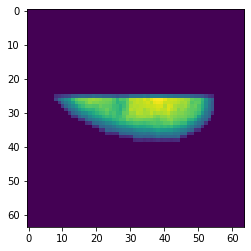

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][0])

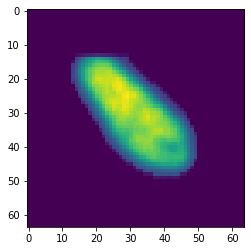

In [9]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][1])

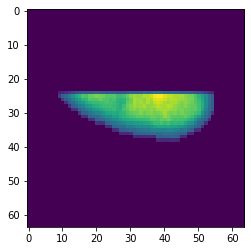

In [10]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][1][0])

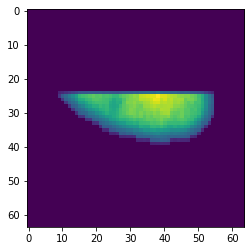

In [11]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][5][0])

In [12]:
# track_info is organized by movie, frame, cell

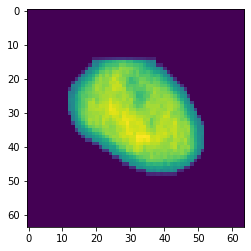

In [13]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][2])

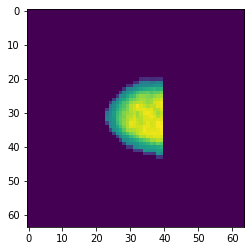

In [14]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][3])

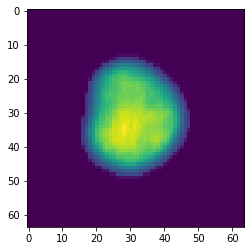

In [15]:
# Got one that is not on the border
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][4])

AttributeError: 'numpy.ndarray' object has no attribute 'set_axis_off'

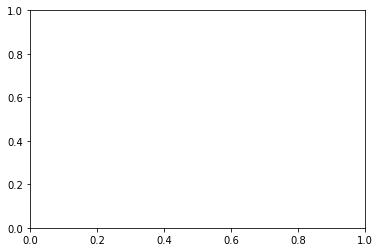

In [16]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][4].set_axis_off())

In [17]:
from PIL import Image  
import PIL

In [18]:
track_info['appearances'][0][0][4].save('../poster_images/reconstruction_images/padded/padded_original_image.jpeg')

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [19]:
plt.imsave('../poster_images/reconstruction_images/padded/padded_original_image.jpeg', track_info['appearances'][0][0][4])

ValueError: Third dimension must be 3 or 4

In [22]:
track_info['appearances'][0][0][4].shape

(64, 64, 1)

In [23]:
im = Image.fromarray(track_info['appearances'][0][0][4])

TypeError: Cannot handle this data type: (1, 1, 1), <f4

FileNotFoundError: [Errno 2] No such file or directory: '../poster_images/reconstruction_images/padded/padded_original_image.jpeg'

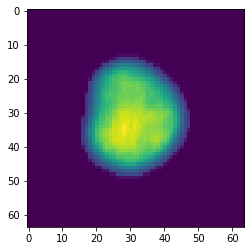

In [24]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][4])
plt.savefig('../poster_images/reconstruction_images/padded/padded_original_image.jpeg')

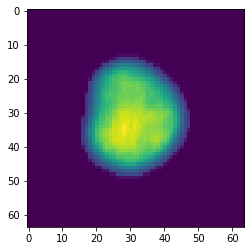

In [25]:
fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][0][0][4])
plt.savefig('../poster_images/reconstruction_images/padded/padded_original_image.jpeg')

In [26]:
# Get reconstructed image

In [27]:
appearances = track_info['appearances']

app_shape = np.shape(appearances)
appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

# Normalize appearances
appearances = norm(appearances)

input_dict = {'appearances': appearances}

output_dict = {'appearances_decoder': appearances}

data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

data = data.repeat().batch(1)

NameError: name 'norm' is not defined

In [28]:
def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

In [29]:
appearances = track_info['appearances']

app_shape = np.shape(appearances)
appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

# Normalize appearances
appearances = norm(appearances)

input_dict = {'appearances': appearances}

output_dict = {'appearances_decoder': appearances}

data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

data = data.repeat().batch(1)

NameError: name 'rescale_intensity' is not defined

In [30]:
appearances.shape

(1848, 71, 64, 64, 1)

In [31]:
# All cells in all batches from 0th in batch 0 to last in last batch

In [33]:
data.shape()

NameError: name 'data' is not defined

In [34]:
track_info['appearances'].shape

(11, 71, 168, 64, 64, 1)

In [35]:
# So track_info['appearances'][0][0][4] should correspond with appearances[4][0]

In [36]:
def get_reconstructed_img(batch, frame, cell):
    appearances = track_info['appearances']

    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

    # Normalize appearances
    appearances = norm(appearances)

    input_dict = {'appearances': appearances}

    output_dict = {'appearances_decoder': appearances}

    data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

    data = data.repeat().batch(1)
    
    it = iter(data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    cell_num = shape[2] * batch + cell + 1

    for cell in range(cell_num):
        nxt = it.next()
    
    inputs = nxt[0]['appearances']
    app_encoded = app_encoder(inputs)
    embeddings = embedding_model(app_encoded)
    reconstructions = app_decoder(embeddings)
    img_reconstruction = reconstructions[0][frame].numpy().astype('float32')
    
    return img_reconstruction

In [37]:
get_reconstructed_img(0, 0, 4)

NameError: name 'rescale_intensity' is not defined

In [38]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

In [39]:
def get_reconstructed_img(batch, frame, cell):
    appearances = track_info['appearances']

    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

    # Normalize appearances
    appearances = norm(appearances)

    input_dict = {'appearances': appearances}

    output_dict = {'appearances_decoder': appearances}

    data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

    data = data.repeat().batch(1)
    
    it = iter(data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    cell_num = shape[2] * batch + cell + 1

    for cell in range(cell_num):
        nxt = it.next()
    
    inputs = nxt[0]['appearances']
    app_encoded = app_encoder(inputs)
    embeddings = embedding_model(app_encoded)
    reconstructions = app_decoder(embeddings)
    img_reconstruction = reconstructions[0][frame].numpy().astype('float32')
    
    return img_reconstruction

In [40]:
reconstructed_img = get_reconstructed_img(0, 0, 4)

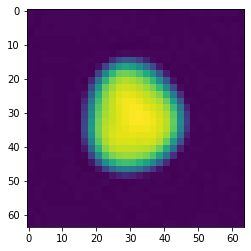

In [41]:
fig, ax = plt.subplots()
ax.imshow(reconstructed_img)

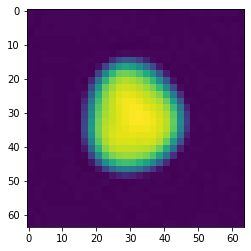

In [43]:
fig, ax = plt.subplots()
ax.imshow(reconstructed_img)
plt.savefig('../poster_images/reconstruction_images/padded/padded_recon_image.jpeg')